### Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn 
import torch.nn.functional as F
from torch import optim
from torch.autograd import grad

from argparse import Namespace
from functools import reduce
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/229 Project'

Mounted at /content/drive
/content/drive/My Drive/229 Project


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DeepXDE Setup

In [3]:
# install DeepXDE
%pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.7 MB/s eta 0:00:00


In [4]:
# import packages

from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow.compat.v1")

import deepxde as dde
import numpy as np

from deepxde.backend import tf

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import random

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [5]:
# set up the problem
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return (
        dy_t
        - dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0.5, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

In [6]:
# set up the model
layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.227078 s

'compile' took 10.883007 s



In [7]:
def gen_testdata():
  full_domain = np.zeros(shape=(25600, 2))
  true_sol = np.zeros(shape=(25600,))
  for time_step in range(100):
    time = time_step * .01
    x = geom.uniform_points(256, True)
    t = np.full(256, time)
    x = np.hstack((x, t.reshape(-1, 1)))

    start = int(256 * time * 100)
    end = start + 256
    full_domain[start:end] = x

    ground_truth = np.exp(-time) * np.sin(np.pi * x[:, 0])
    true_sol[start:end] = ground_truth
  
  return full_domain, true_sol

### Train Model

In [ ]:
# import pickle

# # train the model
# model_preds = {}

# for iter in range(100):
#   losshistory, train_state = model.train(iterations=500)
#   X, y_true = gen_testdata()
#   y_pred = model.predict(X)
#   cur_iter = (iter + 1) * 500
#   model_preds[cur_iter] = y_pred

# with open('model_preds_diffusion.pkl', 'wb') as f:
#   pickle.dump(model_preds, f)

Training model...

0         [7.50e+00, 2.76e-01, 1.38e-01]    [9.27e+00, 2.76e-01, 1.38e-01]    [1.37e+00]    
500       [3.15e-03, 3.98e-03, 1.00e-03]    [4.12e-03, 3.98e-03, 1.00e-03]    [1.13e-01]    

Best model at step 500:
  train loss: 8.13e-03
  test loss: 9.11e-03
  test metric: [1.13e-01]

'train' took 5.624886 s

Training model...

Step      Train loss                        Test loss                         Test metric   
500       [3.15e-03, 3.98e-03, 1.00e-03]    [4.12e-03, 3.98e-03, 1.00e-03]    [1.13e-01]    
1000      [1.18e-03, 1.38e-03, 2.03e-04]    [1.59e-03, 1.38e-03, 2.03e-04]    [6.61e-02]    

Best model at step 1000:
  train loss: 2.76e-03
  test loss: 3.18e-03
  test metric: [6.61e-02]

'train' took 1.325740 s

Training model...

Step      Train loss                        Test loss                         Test metric   
1000      [1.18e-03, 1.38e-03, 2.03e-04]    [1.59e-03, 1.38e-03, 2.03e-04]    [6.61e-02]    
1500      [1.16e-03, 5.88e-04, 1.34e-04]    [1.

### Fourier Helper Functions

In [8]:
def get_fft(y, sampling_rate):
  # Calculate the Fourier transform of f(x)
  fourier = np.fft.fft(y.squeeze())

  length = len(y)

  # Calculate the corresponding frequencies
  freq = np.fft.fftfreq(length, 1/sampling_rate)

  results = list(zip(freq, np.abs(fourier)))
  filtered = [(x, y) for (x, y) in results if x > 0]
  results = list(zip(*filtered))

  return results

In [9]:
def compare_solutions(t, y_true, y_pred):
  start = int(256 * t * 100)
  end = start + 256

  fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))

  ax0.plot(X[:, 0][start:end], y_true[start:end], "b-", label="Exact")
  ax0.plot(X[:, 0][start:end], y_pred[start:end], "r--", label="Prediction")
  ax0.legend()
  ax0.set_title(f"Comparing Solutions at Time {t}")
  ax0.set_xlabel("x")
  ax0.set_ylabel("u(x, t)")

  true_freq, true_fourier = get_fft(y_true[start:end], 256/2)
  pred_freq, pred_fourier = get_fft(y_pred[start:end], 256/2)
  ax1.plot(true_freq, true_fourier, "b-", label="Exact")
  ax1.plot(pred_freq, pred_fourier, "r--", label="Prediction")
  ax1.legend()
  ax1.set_title(f"Comparing Fourier Transforms of Solutions at Time {t}")
  ax1.set_xlabel("Frequency")
  ax1.set_ylabel("Amplitude")

  fourier_diff = abs(np.array(true_fourier) - np.array(pred_fourier))
  ax2.plot(true_freq, fourier_diff, "b-")
  ax2.set_title(f"Difference in Fourier Transforms of Solutions at Time {t}")
  ax2.set_xlabel("Frequency")
  ax2.set_ylabel("Absolute Difference in Amplitude")
  
  plt.show()

In [10]:
import pandas as pd
from matplotlib.colors import LogNorm, Normalize

def plot_spectral_dynamics(all_preds, y_true, t):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

    start = int(256 * t * 100)
    end = start + 256
    
    true_freq, true_fourier = get_fft(y_true[start:end], 256/2)

    pct_dict = {"iter": [], "freq": [], "value": []}
    error_dict = {"iter": [], "freq": [], "value": []}
    # Compute spectra for all frames
    for iter, pred in all_preds.items(): 
        if iter % 1000 == 0 or iter == 500:
          pred_freq, pred_fourier = get_fft(pred[start:end], 256/2)
          pct_diff = abs(np.array(pred_fourier) - np.array(true_fourier))/np.array(true_fourier) * 100
          abs_diff = abs(np.array(pred_fourier) - np.array(true_fourier))

          for idx, freq in enumerate(pred_freq):
            pct_dict["iter"].append(iter)
            pct_dict['freq'].append(freq)
            pct_dict['value'].append(pct_diff[idx])

            error_dict["iter"].append(iter)
            error_dict['freq'].append(freq)
            error_dict['value'].append(abs_diff[idx])


    pct_diffs = pd.DataFrame(data = pct_dict)
    pct_diffs = pct_diffs.round(3)
    pct_diffs = pct_diffs.pivot("iter", "freq", "value")
    sns.heatmap(pct_diffs, yticklabels=3, xticklabels=10, vmin=0., vmax=100, cbar_kws={'label': 'Percentage Error in Amplitude'}, ax=ax0, cmap="BuPu")
    ax0.invert_yaxis()
    ax0.set_xlabel("Frequency")
    ax0.set_ylabel("Training Iteration")
    ax0.set_title(f"Frequency Dynamics of Predicted Solution at t = {t}")


    abs_diffs = pd.DataFrame(data = error_dict)
    abs_diffs = abs_diffs.round(3)
    abs_diffs = abs_diffs.pivot("iter", "freq", "value")
    sns.heatmap(abs_diffs, yticklabels=3, xticklabels=10, vmin=0., vmax=max(error_dict['value']), cbar_kws={'label': 'Absolute Error in Amplitude'}, ax=ax1, cmap="BuPu")
    ax1.invert_yaxis()
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Training Iteration")
    ax1.set_title(f"Frequency Dynamics of Predicted Solution at t = {t}")

    plt.show()

### Visualizations

In [11]:
import pickle

# compare the true solution with the predicted solution
X, y_true = gen_testdata()

with open('model_preds_diffusion.pkl', 'rb') as f:
    all_preds = pickle.load(f)

<ipython-input-10-95e140d01a04>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-10-95e140d01a04>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


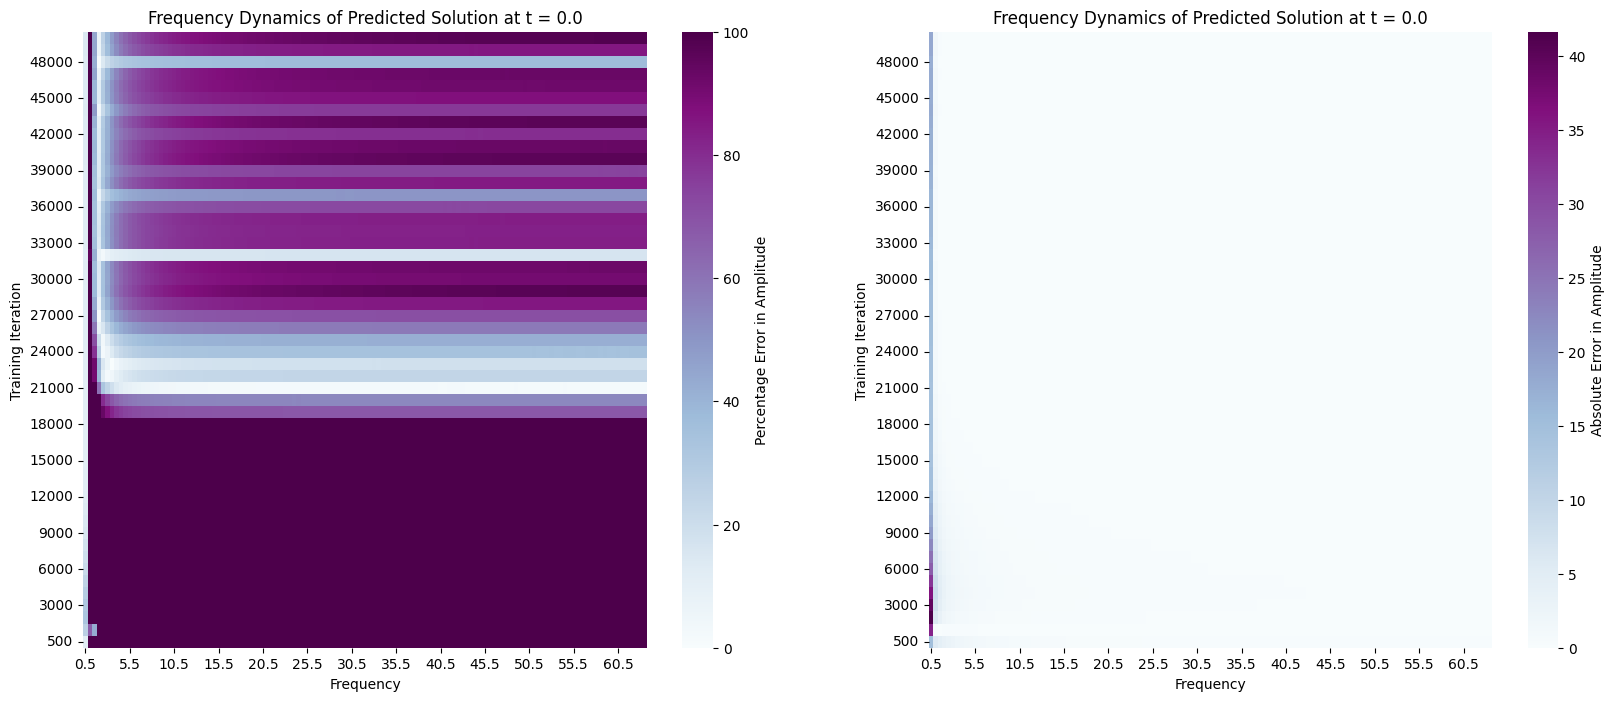

<ipython-input-10-95e140d01a04>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-10-95e140d01a04>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


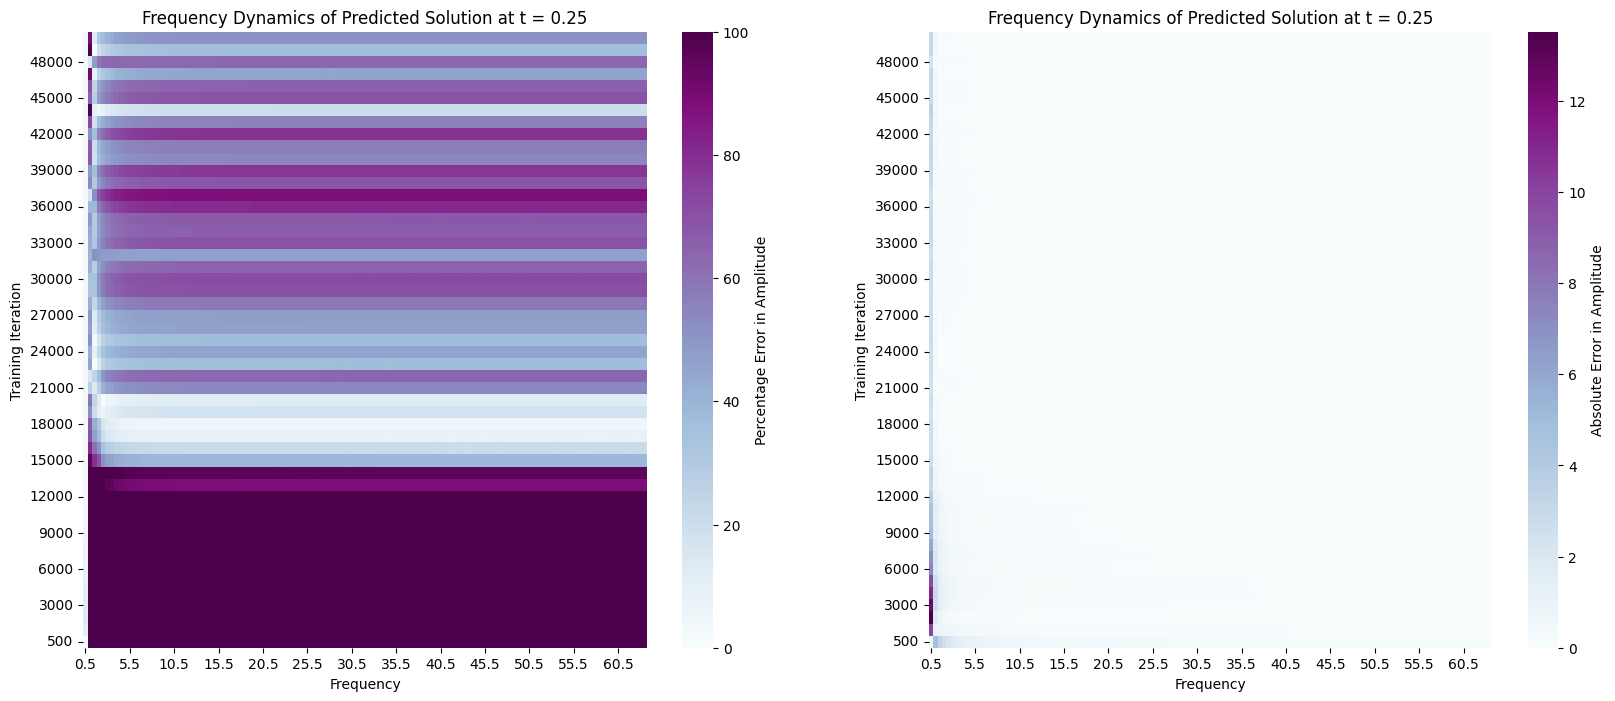

<ipython-input-10-95e140d01a04>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-10-95e140d01a04>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


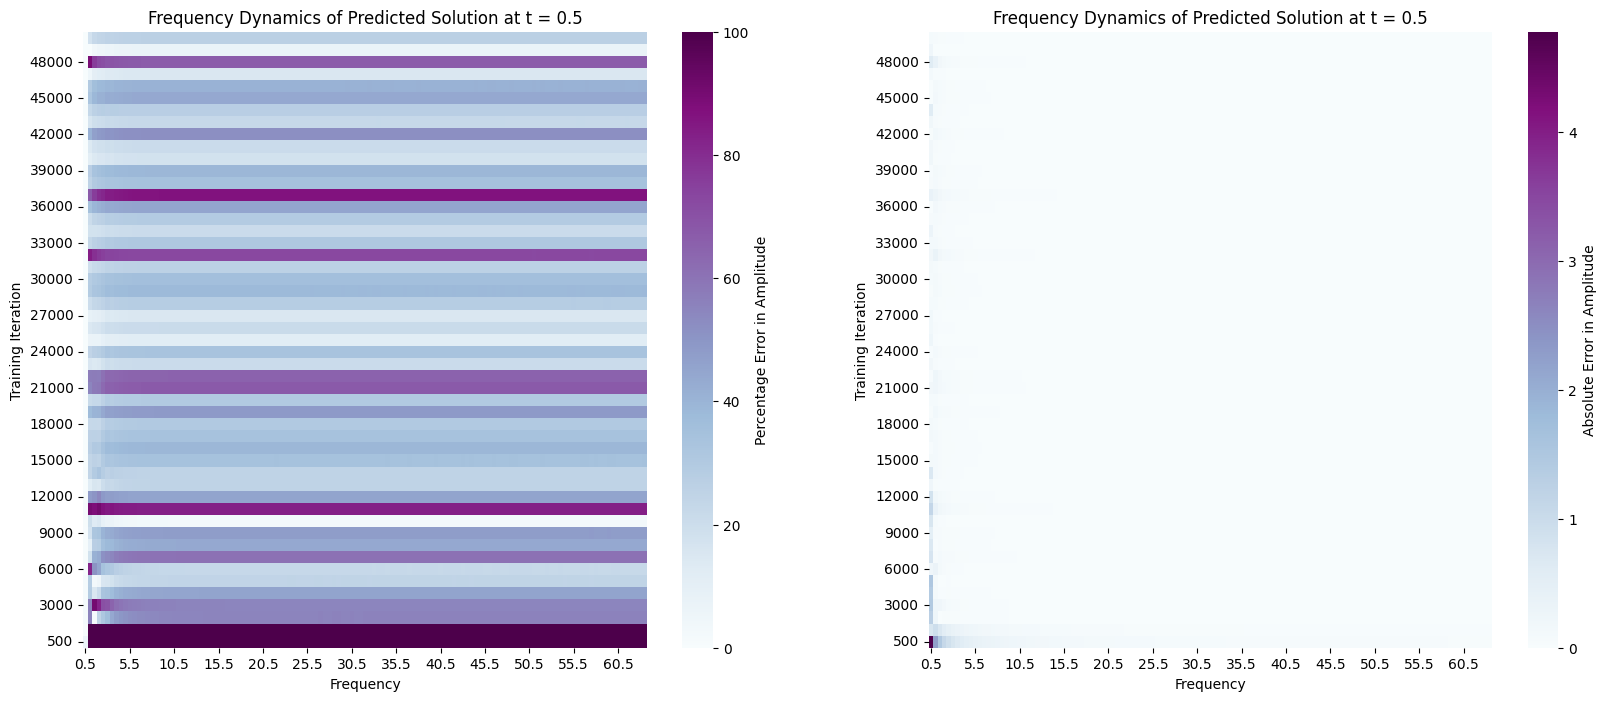

<ipython-input-10-95e140d01a04>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-10-95e140d01a04>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


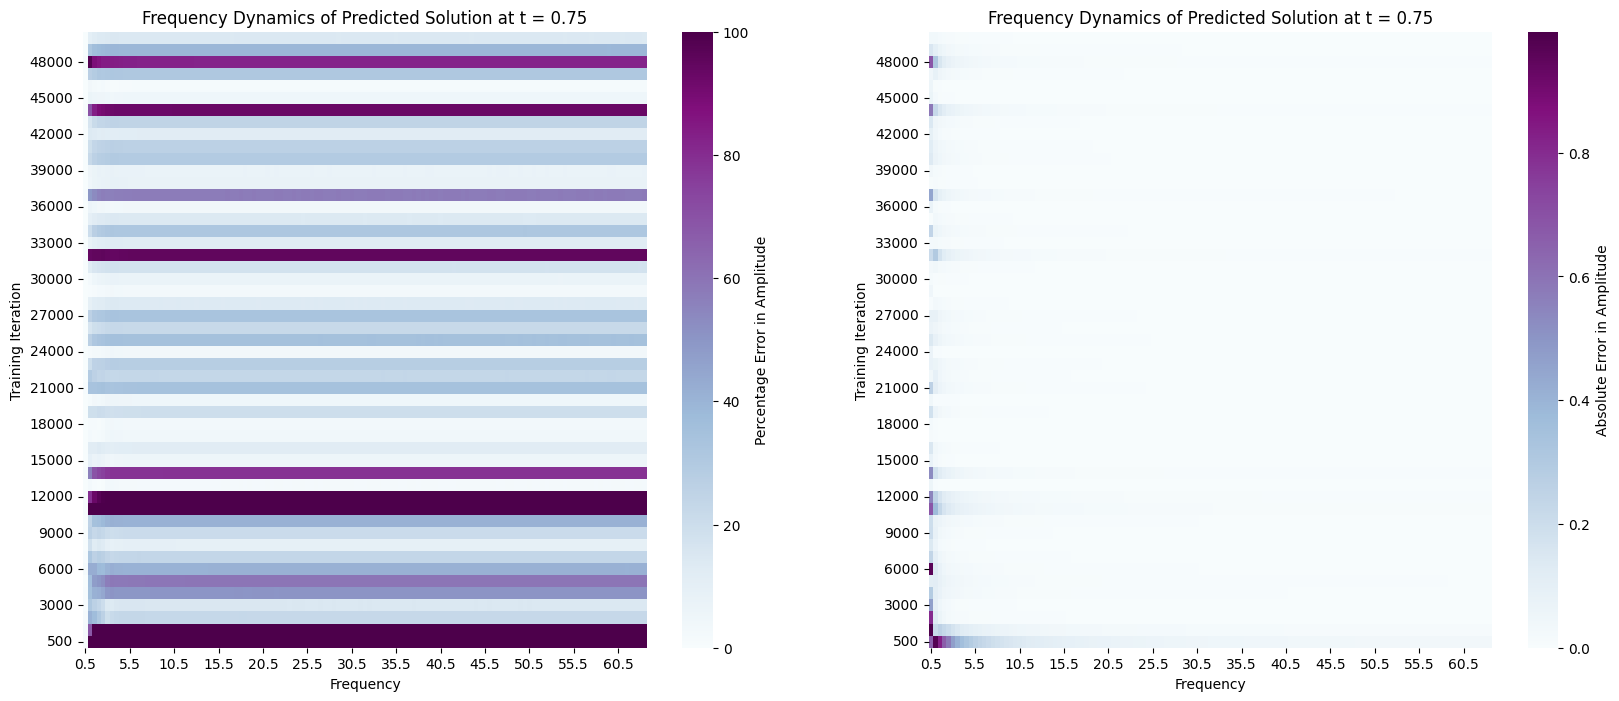

<ipython-input-10-95e140d01a04>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-10-95e140d01a04>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


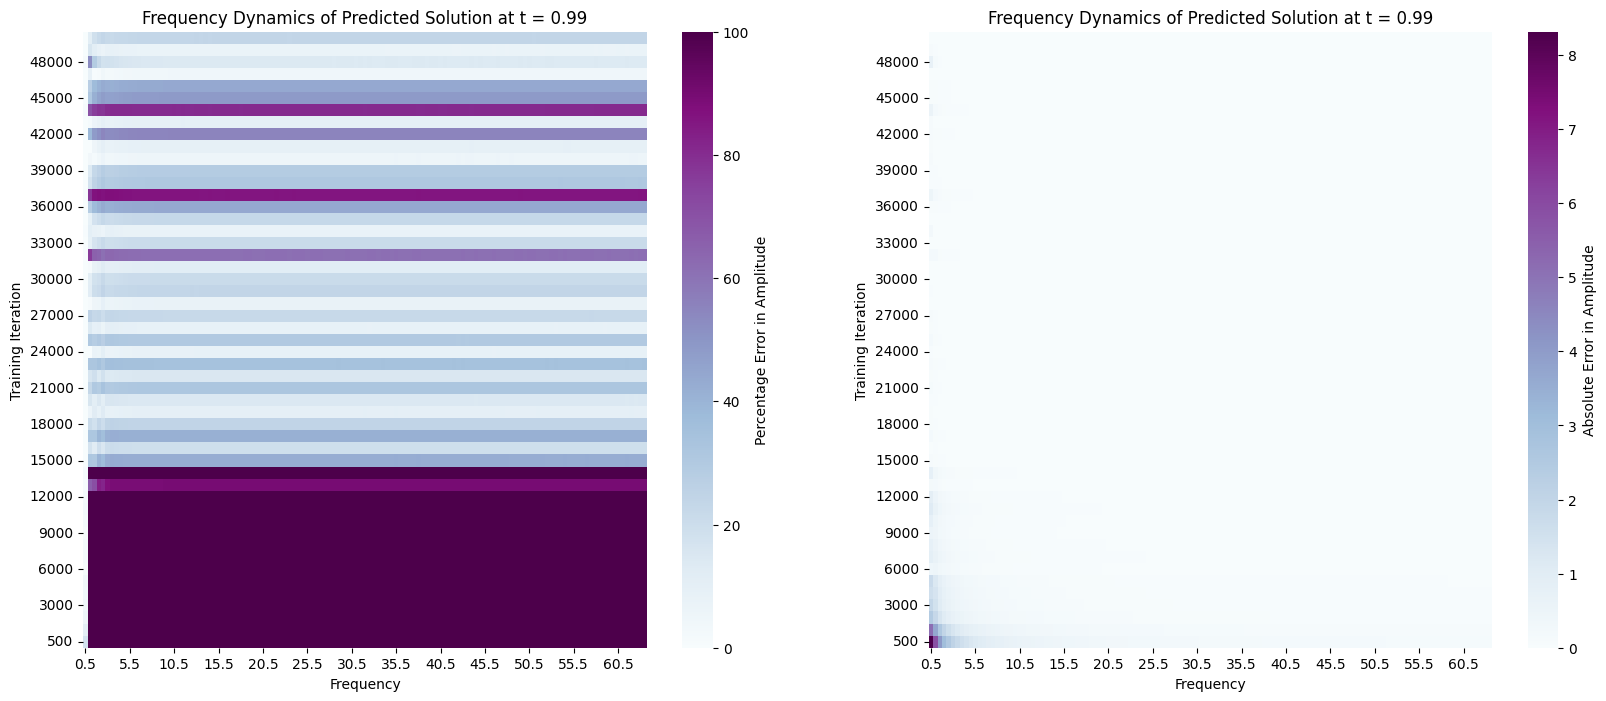

In [12]:
plot_spectral_dynamics(all_preds, y_true, 0.00)
plot_spectral_dynamics(all_preds, y_true, 0.25)
plot_spectral_dynamics(all_preds, y_true, 0.50)
plot_spectral_dynamics(all_preds, y_true, 0.75)
plot_spectral_dynamics(all_preds, y_true, 0.99)

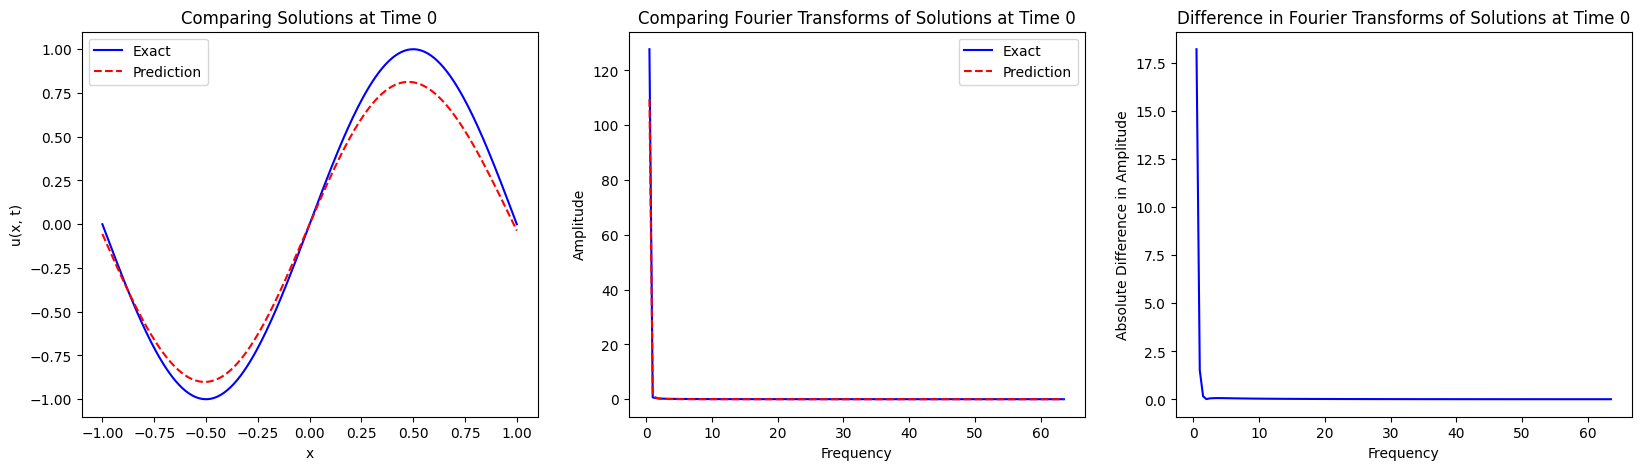

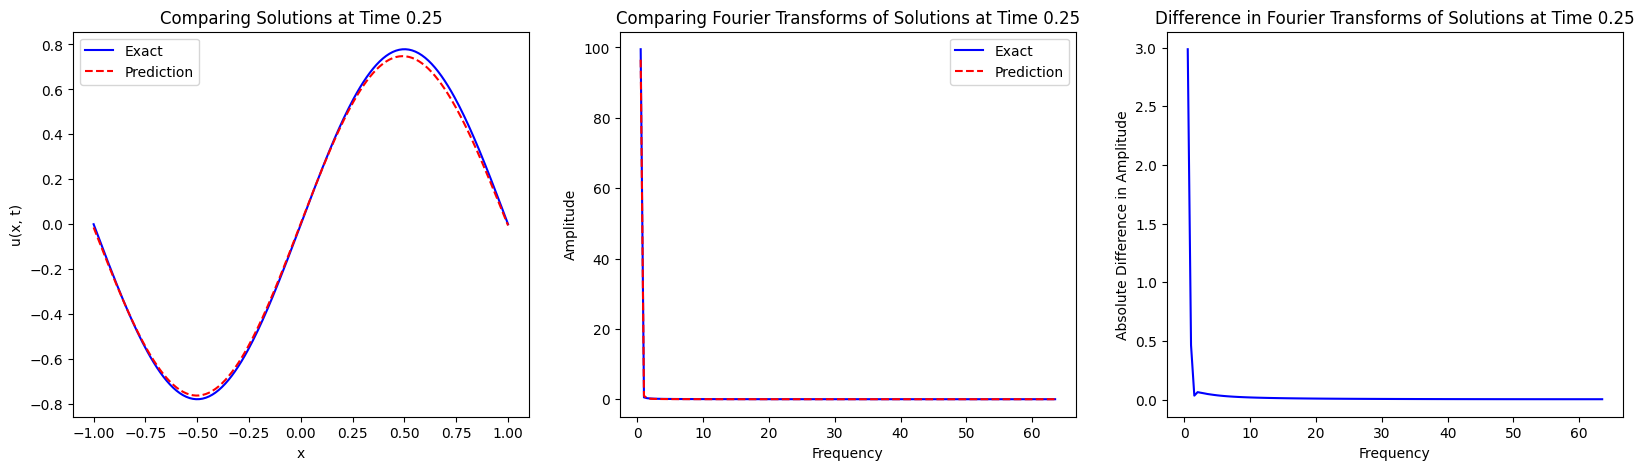

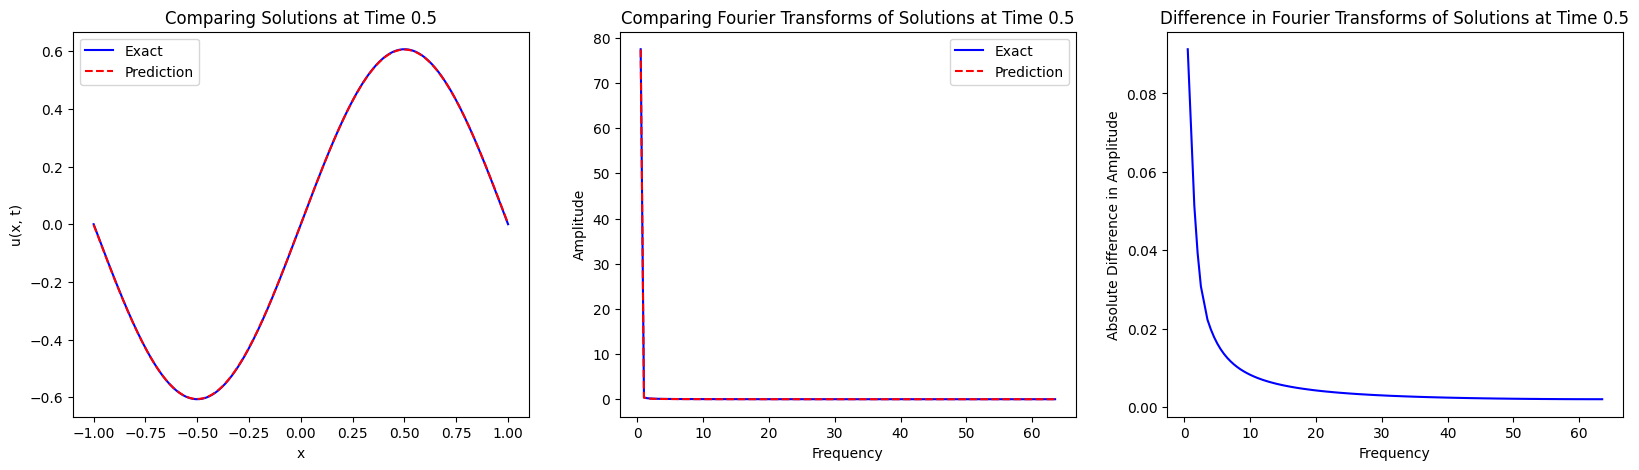

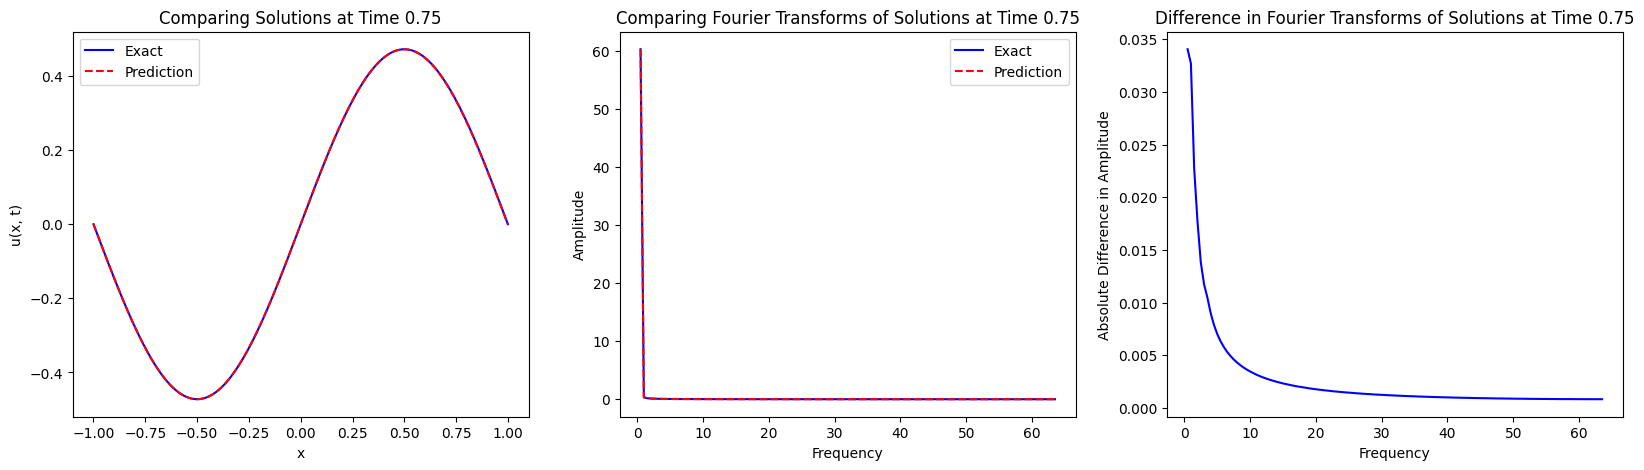

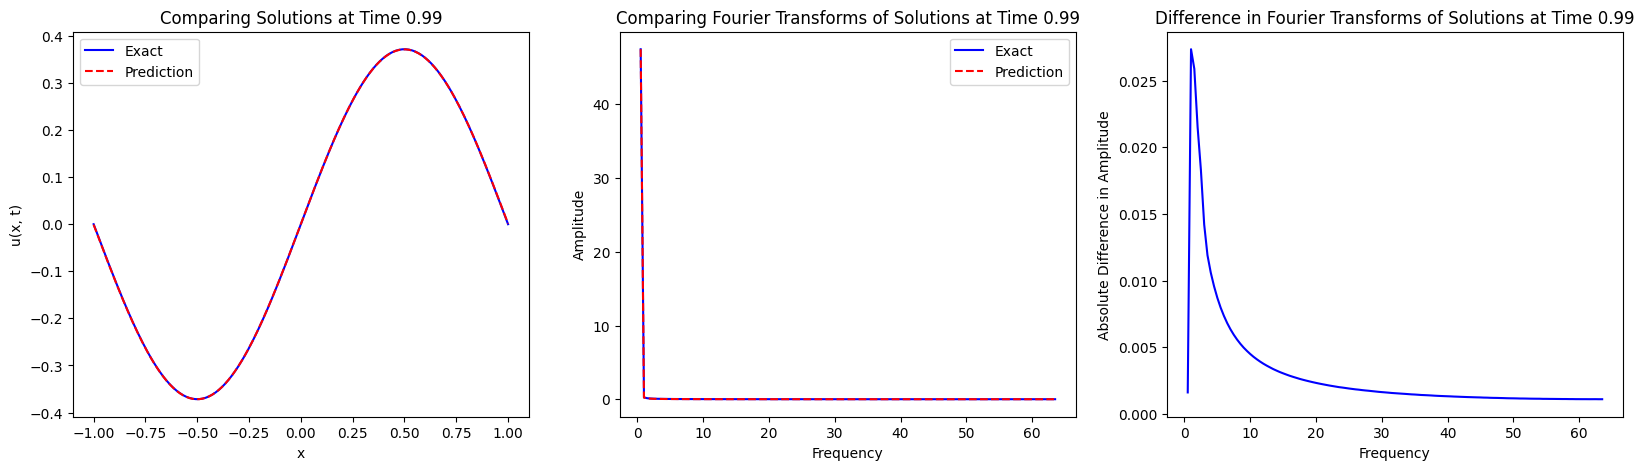

In [13]:
compare_solutions(0, y_true, all_preds[50000])
compare_solutions(0.25, y_true, all_preds[50000])
compare_solutions(0.5, y_true, all_preds[50000])
compare_solutions(0.75, y_true, all_preds[50000])
compare_solutions(0.99, y_true, all_preds[50000])